In [1]:
import matplotlib.pyplot as plt

In [11]:
def plot_width_result(bb_result, pb_result, title, xsize, ysize):
    plt.figure(figsize=(xsize, ysize))

    if (bb_result is not None):
        x_bb, y_bb = zip(*bb_result)
        plt.plot(x_bb, y_bb, label='Bit-Blasting', marker='o', color='b')
    
    x_pb, y_pb = zip(*pb_result)
    plt.plot(x_pb, y_pb, label='PB-Blasing', marker='s', color='r')
    
    plt.xlabel('Bit-Vector Width')
    plt.ylabel('Running Time (ms)')
    plt.title(title)
    
    plt.legend()
    
    plt.grid(True)
    plt.show()

def plot_regression_result(bb_result, pb_result, sizex, sizey, label='Running Time(ms)', title='Comparison of Running Times'):
    x_values = range(1, len(bb_result) + 1)
    
    plt.figure(figsize=(sizex, sizey))

    if (bb_result is not None):
        plt.plot(x_values, bb_result, label='Bit-Blasing', marker='o', color='b')
    if (pb_result is not None):    
        plt.plot(x_values, pb_result, label='PB-Blasting', marker='s', color='r')
    
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel(label)
    plt.title(title)
    
    plt.legend()
    
    plt.grid(True)
    plt.show()

def plot_list_of_values(values, sizex, sizey, dpi, label, ylabel, title, color):
    x_values = range(1, len(values) + 1)
    
    plt.figure(figsize=(sizex, sizey), dpi=dpi)

    plt.plot(x_values, values, label=label, marker='o', color=color)
    
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.legend()
    
    plt.grid(True)
    plt.show()

## Problem: Yoni
$$
a \cdot b \neq (a\ \& \sim b) \cdot (\sim a\ \&\ b) + (a\ \&\ b) \cdot (a\ |\ b)
$$
```
(set-logic QF_BV)
(declare-const a (_ BitVec SIZE))
(declare-const b (_ BitVec SIZE))
(assert
  (distinct
    (bvmul a b)
    (bvadd
      (bvmul (bvand a (bvnot b)) (bvand (bvnot a) b))
      (bvmul (bvand a b) (bvor a b)))
  )
)
(check-sat)
```

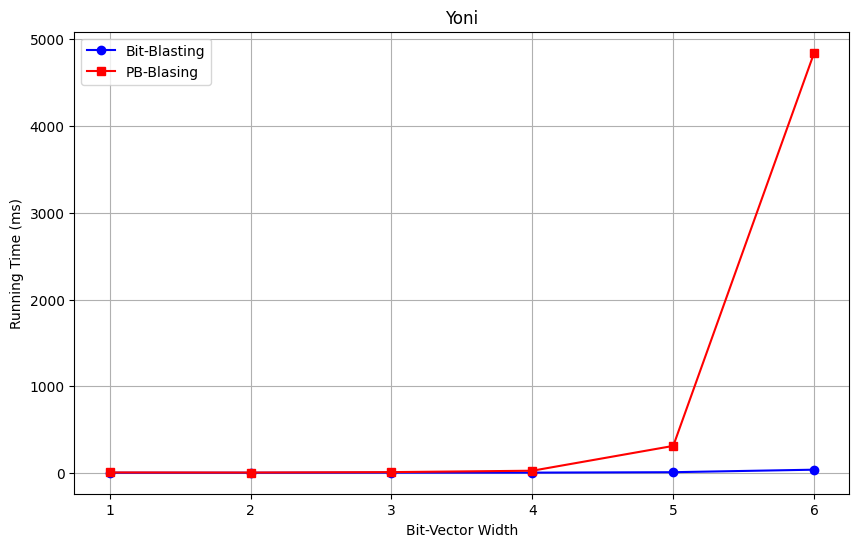

In [3]:
bb_result = [(1, 5), (2, 5), (3, 6), (4, 6), (5, 11), (6, 40),]
pb_result = [(1, 8), (2, 7), (3, 12), (4, 28), (5, 314), (6, 4844),]
plot_width_result(bb_result, pb_result, "Yoni", 10, 6)

## Problem: Jakob
$$
k\cdot z \geq (x\ \&\ k) \cdot z
$$
```
(set-logic QF_BV)

(declare-const x (_ BitVec DOUBLE))
(declare-const x_temp (_ BitVec SIZE))
(assert (= x ((_ zero_extend SIZE) x_temp)))

(declare-const k (_ BitVec DOUBLE))
(declare-const k_temp (_ BitVec SIZE))
(assert (= k ((_ zero_extend SIZE) k_temp)))

(declare-const z (_ BitVec DOUBLE))
(declare-const z_temp (_ BitVec SIZE))
(assert (= z ((_ zero_extend SIZE) z_temp)))

(assert (= k_temp #bCONSTANT))

(assert
	(bvult
		(bvmul k z)
		(bvmul (bvand x k) z)
	)
)

(check-sat)
```

from https://jakobnordstrom.se/docs/publications/MultiplierVerification_FMCAD.pdf

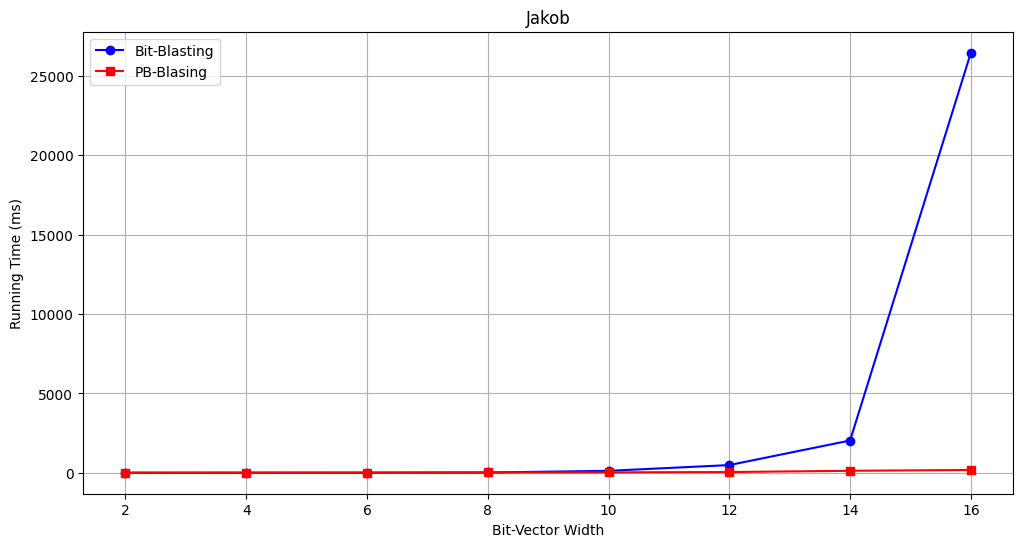

In [4]:
bb_result = [(2, 4), (4, 5), (6, 7), (8, 19), (10, 123), (12, 486), (14, 2034), (16, 26469),]
pb_result = [(2, 7), (4, 10), (6, 13), (8, 23), (10, 27), (12, 47), (14, 126), (16, 176),]
plot_width_result(bb_result, pb_result, "Jakob", 12, 6)

**Important: for widths over 16, we get an overflow on the coefficients of the PB multiplication**

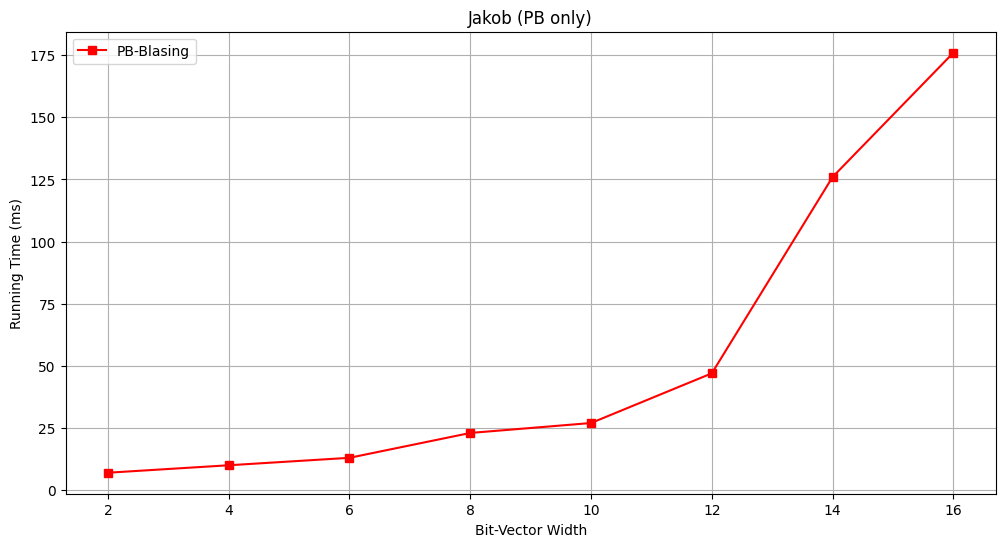

In [5]:
pb_result = [(2, 7), (4, 10), (6, 13), (8, 23), (10, 27), (12, 47), (14, 126), (16, 176),]
plot_width_result(None, pb_result, "Jakob (PB only)", 12, 6)

Jakob's inequality ($k \cdot z \geq (x\ \&\ k) \cdot z$) holds only when overflows are disregarded. Therefore, to represent this inequality in an SMT problem, bit-vector variables of the required width are first created, and then these bit-vectors are extended to double their size, padded with zeroes. This means that the SMT solver reasons about bit-vectors twice the width of those directly handled by the PB-solver.

To illustrate, if a bit-vector of width 20 is being tested, the PB variant uses bit-vectors of width 20, with additional variables introduced only during multiplication. In contrast, SMT solvers define the problem using bit-vectors of width 40. This leads to an unfair comparison, as the search space for valid solutions grows exponentially with the bit-vector width. In cvc5, PB-blasting the multiplication yields a bit-vector result of width 80.

## Regression Tests

cvc5's regression sets include 404 tests for bit-vectors (377 from `regress0/bv`, 26 from `regress1/bv`, and 1 from `regress2/bv`) . When these tests are run using PB-blasting:

- 231 produce the expected results.
- 3 conflict with the default Bit-Blasting results.
- 179 do not work.

I am somewhat confident that the PB-blasting strategies are correct. If this is the case, the errors may originate from two sources: either RoundingSat is malfunctioning, or there is an issue with the integration between the PB-Blasting module and cvc5, such as incorrect conflict generation or a missing component.

From the tests that successfully run, we can compare the performance of Bit-Blasting and PB-Blasting as follows:

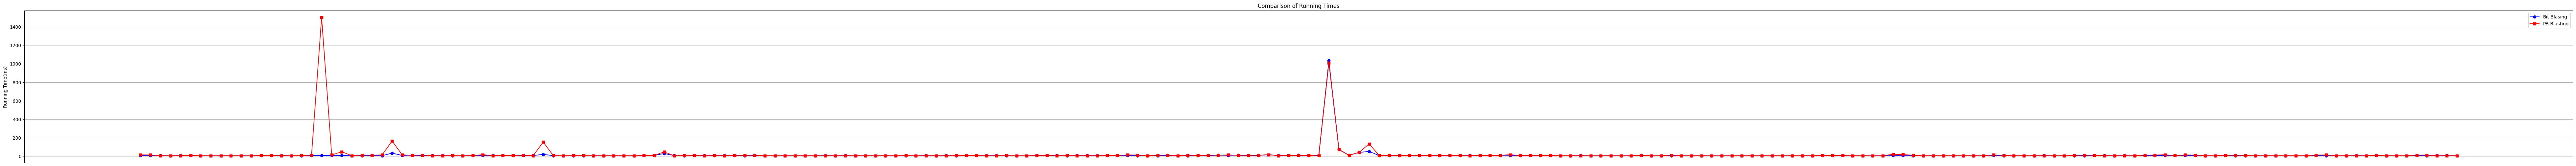

In [6]:
bb_result = [7, 6, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 6, 7, 7, 5, 5, 6, 8, 7, 8, 5, 5, 6, 5, 33, 8, 10, 6, 6, 6, 5, 5, 6, 9, 7, 6, 6, 6, 6, 20, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 29, 6, 5, 6, 6, 6, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 7, 6, 6, 6, 5, 5, 5, 6, 9, 6, 5, 6, 6, 6, 6, 6, 7, 5, 5, 5, 6, 5, 5, 8, 7, 10, 9, 10, 6, 8, 16, 7, 6, 10, 6, 6, 1033, 72, 10, 40, 52, 6, 9, 8, 7, 6, 6, 6, 6, 6, 6, 6, 7, 9, 9, 6, 6, 6, 6, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 8, 6, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 5, 6, 5, 7, 7, 8, 7, 7, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 6, 5, 6, 5, 5, 5, 6, 5, 6, 6, 5,]
pb_result = [14, 13, 5, 5, 5, 9, 5, 4, 5, 5, 5, 4, 7, 8, 5, 5, 6, 12, 1501, 13, 48, 5, 12, 11, 13, 164, 14, 9, 12, 5, 5, 6, 5, 6, 16, 5, 9, 6, 11, 5, 153, 6, 5, 6, 6, 5, 5, 5, 5, 5, 7, 7, 46, 5, 6, 6, 5, 6, 5, 9, 9, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 8, 7, 4, 4, 6, 4, 5, 6, 6, 5, 6, 5, 5, 5, 7, 8, 13, 12, 5, 11, 12, 5, 11, 7, 10, 11, 13, 10, 9, 10, 15, 5, 6, 10, 6, 11, 1010, 70, 9, 41, 133, 6, 9, 8, 7, 6, 6, 6, 6, 6, 5, 6, 7, 9, 16, 6, 6, 6, 8, 5, 5, 5, 4, 5, 5, 4, 5, 10, 5, 5, 12, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 6, 5, 5, 4, 5, 20, 17, 10, 5, 5, 5, 5, 5, 5, 5, 13, 9, 5, 5, 5, 5, 5, 5, 9, 11, 9, 5, 5, 5, 5, 11, 12, 15, 6, 13, 12, 5, 5, 8, 11, 8, 5, 5, 5, 5, 5, 5, 12, 13, 5, 5, 5, 5, 10, 5, 5, 5, 12, 12, 4, 5, 5,]
plot_regression_result(bb_result, pb_result, 100, 6)

## Proof Sizes


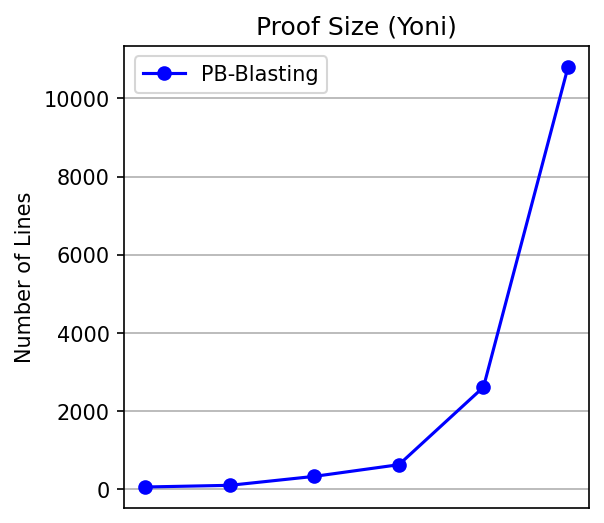

In [7]:
pb_proof_lines = [63, 106, 335, 634, 2618, 10805,]
plot_list_of_values(pb_proof_lines, 4, 4, 150, "PB-Blasting", "Number of Lines", "Proof Size (Yoni)", 'b')

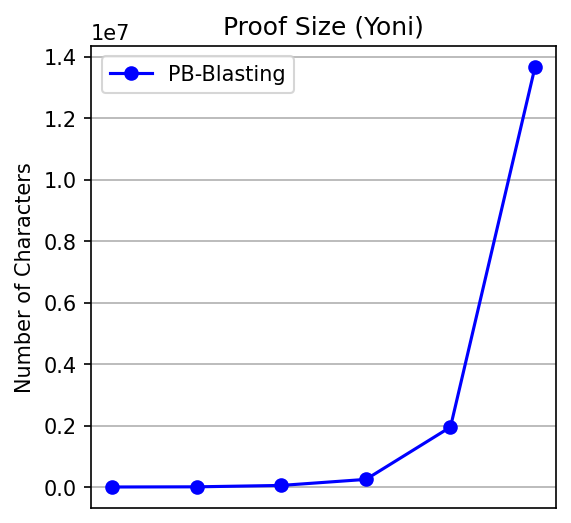

In [8]:
pb_proof_chars = [852, 6534, 52126, 248798, 1952391, 13671133,]
plot_list_of_values(pb_proof_chars, 4, 4, 150, "PB-Blasting", "Number of Characters", "Proof Size (Yoni)", 'b')

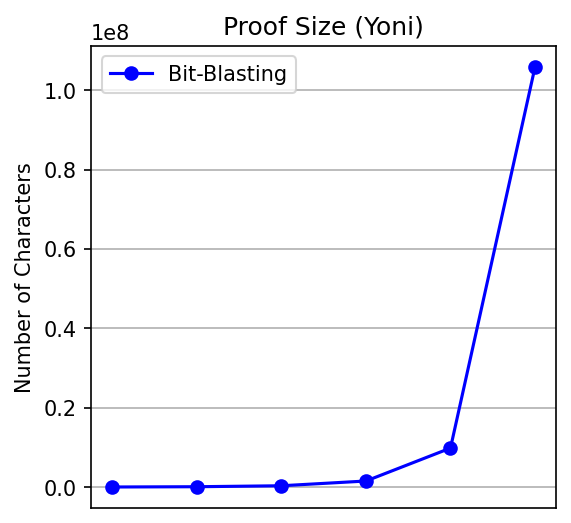

In [9]:
bb_proof_chars = [19678, 89966, 331960, 1527700, 9827387, 105862481,]
plot_list_of_values(bb_proof_chars, 4, 4, 150, "Bit-Blasting", "Number of Characters", "Proof Size (Yoni)", 'b')

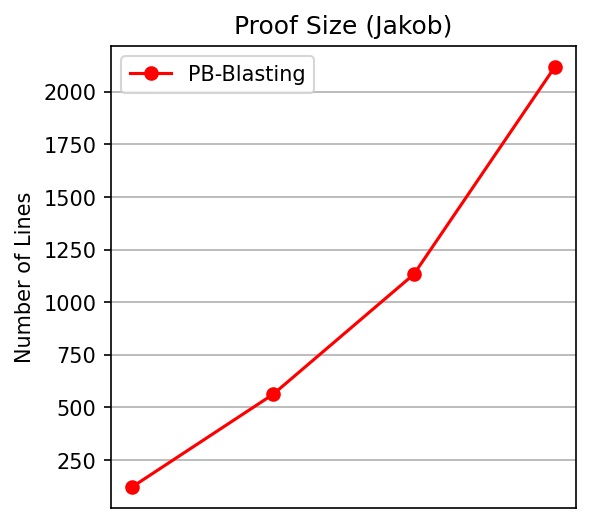

In [12]:
pb_proof_lines = [122, 562, 1133, 2118,]
plot_list_of_values(pb_proof_lines, 4, 4, 150, "PB-Blasting", "Number of Lines", "Proof Size (Jakob)", 'r')

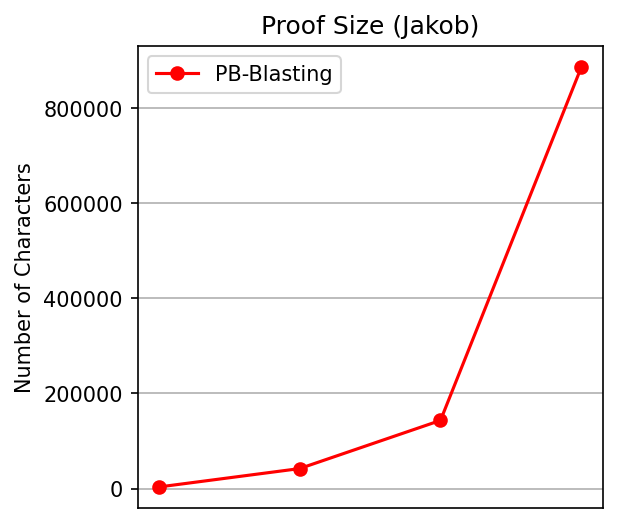

In [13]:
pb_proof_chars = [3436, 42142, 143421, 886379,]
plot_list_of_values(pb_proof_chars, 4, 4, 150, "PB-Blasting", "Number of Characters", "Proof Size (Jakob)", 'r')

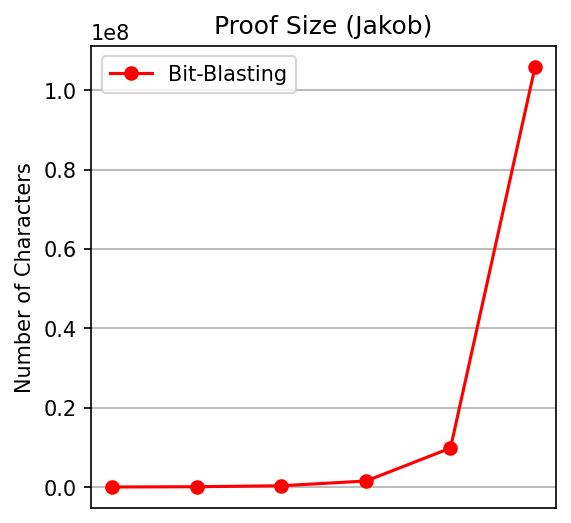

In [14]:
pb_proof_chars = [3436, 42142, 143421, 886379,]
plot_list_of_values(bb_proof_chars, 4, 4, 150, "Bit-Blasting", "Number of Characters", "Proof Size (Jakob)", 'r')

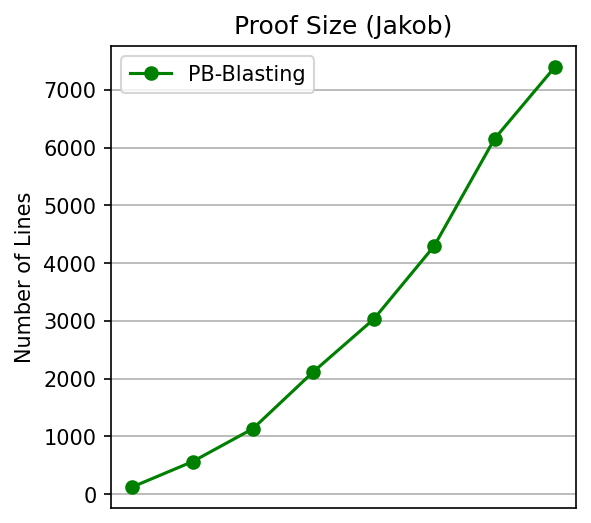

In [17]:
pb_proof_lines = [122, 562, 1133, 2118, 3030, 4295, 6153, 7398,]
plot_list_of_values(pb_proof_lines, 4, 4, 150, "PB-Blasting", "Number of Lines", "Proof Size (Jakob)", 'g')

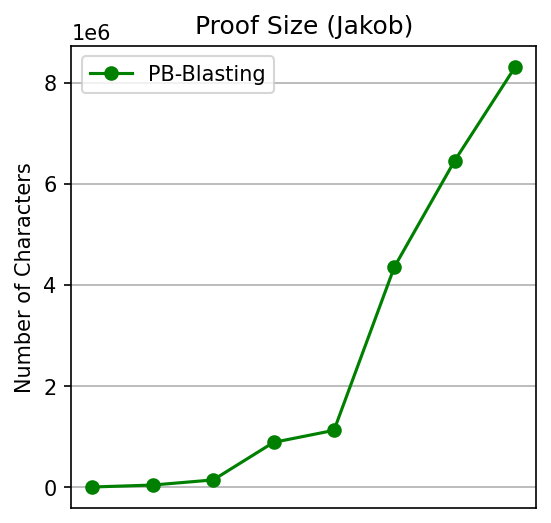

In [19]:
pb_proof_chars = [3436, 42142, 143421, 886379, 1124393, 4356234, 6461608, 8311917,]
plot_list_of_values(pb_proof_chars, 4, 4, 150, "PB-Blasting", "Number of Characters", "Proof Size (Jakob)", 'g')